# Análisis de Correlación entre Variables del Dataset

Este notebook analiza las correlaciones entre las diferentes variables del dataset de precipitación para identificar relaciones significativas y patrones. El análisis ayudará a entender qué variables tienen mayor influencia en los patrones de precipitación y podría guiar el desarrollo de modelos predictivos más precisos.

In [61]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from scipy import stats

# Configuración de visualización
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
sns.set_palette('viridis')

In [62]:
# Detectar si estamos en Google Colab o en entorno local
import os
import sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    dataset_path = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    dataset_path = '/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features.nc'

print(f'Entorno configurado. Usando ruta base: {dataset_path}')

Entorno configurado. Usando ruta base: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/complete_dataset_with_features.nc


In [63]:
# Cargar el dataset con xarray usando chunks para manejar datasets grandes
try:
    ds = xr.open_dataset(dataset_path, chunks={'time': 20, 'latitude': 100, 'longitude': 100})
    print(f"Dataset cargado correctamente con {len(ds.data_vars)} variables.")
    print(f"\nDimensiones del dataset:")
    print(ds.dims)
    
    print(f"\nVariables disponibles:")
    for var in ds.data_vars:
        print(f"- {var}: {ds[var].dims}, {ds[var].shape}")
        
    # Mostrar rango de fechas
    if 'time' in ds.dims:
        print(f"\nRango de fechas: {ds.time.values[0]} a {ds.time.values[-1]}")
        print(f"Total de pasos de tiempo: {len(ds.time)}")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

Dataset cargado correctamente con 11 variables.

Dimensiones del dataset:
FrozenMappingWarningOnValuesAccess({'time': 530, 'latitude': 62, 'longitude': 66})

Variables disponibles:
- total_precipitation: ('time', 'latitude', 'longitude'), (530, 62, 66)
- max_daily_precipitation: ('time', 'latitude', 'longitude'), (530, 62, 66)
- min_daily_precipitation: ('time', 'latitude', 'longitude'), (530, 62, 66)
- daily_precipitation_std: ('time', 'latitude', 'longitude'), (530, 62, 66)
- month_sin: ('time', 'latitude', 'longitude'), (530, 62, 66)
- month_cos: ('time', 'latitude', 'longitude'), (530, 62, 66)
- doy_sin: ('time', 'latitude', 'longitude'), (530, 62, 66)
- doy_cos: ('time', 'latitude', 'longitude'), (530, 62, 66)
- elevation: ('latitude', 'longitude'), (62, 66)
- slope: ('latitude', 'longitude'), (62, 66)
- aspect: ('latitude', 'longitude'), (62, 66)

Rango de fechas: 1981-01-01T00:00:00.000000000 a 2025-02-01T00:00:00.000000000
Total de pasos de tiempo: 530


## 1. Preparación de los Datos para Análisis de Correlación

Para realizar el análisis de correlación, necesitamos extraer datos de las variables en puntos específicos o promediar sobre regiones. Esto nos permitirá crear matrices de correlación manejables.

In [64]:
# Función para extraer series temporales de puntos o regiones específicas
def extract_timeseries(dataset, variables=None, method='point', lat=None, lon=None, lat_range=None, lon_range=None):
    """Extrae series temporales de un conjunto de datos xarray.
    
    Args:
        dataset: Dataset de xarray
        variables: Lista de variables a extraer (None para todas)
        method: 'point' para un punto específico, 'region' para promediar sobre una región
        lat, lon: Coordenadas específicas para method='point'
        lat_range, lon_range: Tuplas (min, max) para delimitar región cuando method='region'
    
    Returns:
        pandas.DataFrame con las series temporales
    """
    if variables is None:
        variables = list(dataset.data_vars.keys())
    
    data_dict = {}
    
    for var in variables:
        if method == 'point' and lat is not None and lon is not None:
            # Extraer la serie temporal para un punto específico
            ts = dataset[var].sel(latitude=lat, longitude=lon, method='nearest').compute()
            data_dict[var] = ts.values
        
        elif method == 'region' and lat_range is not None and lon_range is not None:
            # Extraer y promediar sobre una región
            region_slice = dataset[var].sel(
                latitude=slice(lat_range[0], lat_range[1]), 
                longitude=slice(lon_range[0], lon_range[1])
            )
            # Promediar espacialmente
            ts = region_slice.mean(dim=['latitude', 'longitude']).compute()
            data_dict[var] = ts.values
    
    # Crear DataFrame con las series temporales
    if method == 'point':
        df = pd.DataFrame(data_dict, index=dataset.time.values)
        df.index.name = 'time'
    else:  # region
        df = pd.DataFrame(data_dict, index=dataset.time.values)
        df.index.name = 'time'
        
    return df

In [65]:
# Definir puntos o regiones de interés para análisis
# Por ejemplo, podemos analizar un punto central o un promedio regional
try:
    # Obtener los límites del área de estudio
    min_lat, max_lat = float(ds.latitude.min()), float(ds.latitude.max())
    min_lon, max_lon = float(ds.longitude.min()), float(ds.longitude.max())
    
    # Coordenadas para punto central
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2
    
    print(f"Área de estudio: Latitud [{min_lat:.4f}, {max_lat:.4f}], Longitud [{min_lon:.4f}, {max_lon:.4f}]")
    print(f"Punto central: Latitud {center_lat:.4f}, Longitud {center_lon:.4f}")
    
    # Definir regiones de interés (por ejemplo, dividir en cuadrantes)
    mid_lat = (min_lat + max_lat) / 2
    mid_lon = (min_lon + max_lon) / 2
    
    regions = {
        'completo': ((min_lat, max_lat), (min_lon, max_lon)),
        'noreste': ((mid_lat, max_lat), (mid_lon, max_lon)),
        'noroeste': ((mid_lat, max_lat), (min_lon, mid_lon)),
        'sureste': ((min_lat, mid_lat), (mid_lon, max_lon)),
        'suroeste': ((min_lat, mid_lat), (min_lon, mid_lon))
    }
    
    print("\nRegiones definidas para análisis:")
    for name, ((lat_min, lat_max), (lon_min, lon_max)) in regions.items():
        print(f"- {name}: Lat [{lat_min:.4f}, {lat_max:.4f}], Lon [{lon_min:.4f}, {lon_max:.4f}]")
        
except Exception as e:
    print(f"Error al definir regiones: {e}")

Área de estudio: Latitud [4.3250, 7.3750], Longitud [-74.9750, -71.7250]
Punto central: Latitud 5.8500, Longitud -73.3500

Regiones definidas para análisis:
- completo: Lat [4.3250, 7.3750], Lon [-74.9750, -71.7250]
- noreste: Lat [5.8500, 7.3750], Lon [-73.3500, -71.7250]
- noroeste: Lat [5.8500, 7.3750], Lon [-74.9750, -73.3500]
- sureste: Lat [4.3250, 5.8500], Lon [-73.3500, -71.7250]
- suroeste: Lat [4.3250, 5.8500], Lon [-74.9750, -73.3500]


## 2. Cálculo de Correlaciones

Calculamos correlaciones entre variables para diferentes regiones. Esto nos permite identificar relaciones significativas que pueden variar espacialmente.

In [66]:
# Extraer series temporales para cada región
try:
    # Seleccionar variables numéricas para análisis de correlación
    num_vars = [var for var in ds.data_vars if np.issubdtype(ds[var].dtype, np.number)]
    
    # Si hay demasiadas variables, seleccionar un subconjunto para la visualización
    if len(num_vars) > 15:  # Límite arbitrario para visualización clara
        print(f"Hay {len(num_vars)} variables numéricas. Seleccionando un subconjunto para visualización.")
        # Priorizar variables importantes (si conocemos cuáles son)
        important_vars = [var for var in num_vars if var in ['precipitation', 'temperature', 'elevation', 'month_sin', 'month_cos']]
        # Completar hasta 10 variables si es necesario
        selected_vars = important_vars + [var for var in num_vars if var not in important_vars][:max(0, 10-len(important_vars))]
    else:
        selected_vars = num_vars
    
    print(f"Variables seleccionadas para análisis de correlación ({len(selected_vars)}):\n{selected_vars}")
    
    # Extraer datos para la región completa
    print("\nExtrayendo series temporales para la región completa...")
    region_name = 'completo'
    (lat_min, lat_max), (lon_min, lon_max) = regions[region_name]
    df_region = extract_timeseries(ds, variables=selected_vars, method='region', 
                                  lat_range=(lat_min, lat_max), 
                                  lon_range=(lon_min, lon_max))
    
    print(f"Series temporales extraídas. Forma del DataFrame: {df_region.shape}")
    
    # Mostrar estadísticas básicas
    print("\nEstadísticas básicas de las variables:")
    display(df_region.describe())
except Exception as e:
    print(f"Error al extraer series temporales: {e}")

Variables seleccionadas para análisis de correlación (11):
['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']

Extrayendo series temporales para la región completa...
Series temporales extraídas. Forma del DataFrame: (530, 11)

Estadísticas básicas de las variables:


,total_precipitation,max_daily_precipitation,min_daily_precipitation,daily_precipitation_std,month_sin,month_cos,doy_sin,doy_cos,elevation,slope,aspect
count,530.000000,530.000000,530.000000,530.000000,5.300000e+02,5.300000e+02,530.000000,530.000000,5.300000e+02,530.000000,530.000000
mean,186.788589,35.678318,0.000035,9.219022,2.577406e-03,2.577406e-03,0.005143,0.006681,1.274799e+03,87.748192,159.501617
std,80.854126,8.278820,0.000680,2.343380,7.077700e-01,7.077700e-01,0.707681,0.707819,8.875951e-12,0.000443,0.000901
min,19.991331,11.294651,0.000000,2.372608,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,1.274799e+03,87.748199,159.501617
25%,114.691837,31.095257,0.000000,7.850176,-5.000000e-01,-5.000000e-01,-0.513901,-0.503720,1.274799e+03,87.748199,159.501617
50%,206.054520,36.334696,0.000000,9.559538,1.224647e-16,6.123234e-17,0.017202,0.005376,1.274799e+03,87.748199,159.501617
75%,247.421993,40.750995,0.000000,10.748975,7.745189e-01,7.745189e-01,0.523094,0.852275,1.274799e+03,87.748199,159.501617
max,458.896210,102.809433,0.015549,22.253433,1.000000e+00,1.000000e+00,0.999986,0.999852,1.274799e+03,87.748199,159.501617


Matrices de correlación calculadas exitosamente


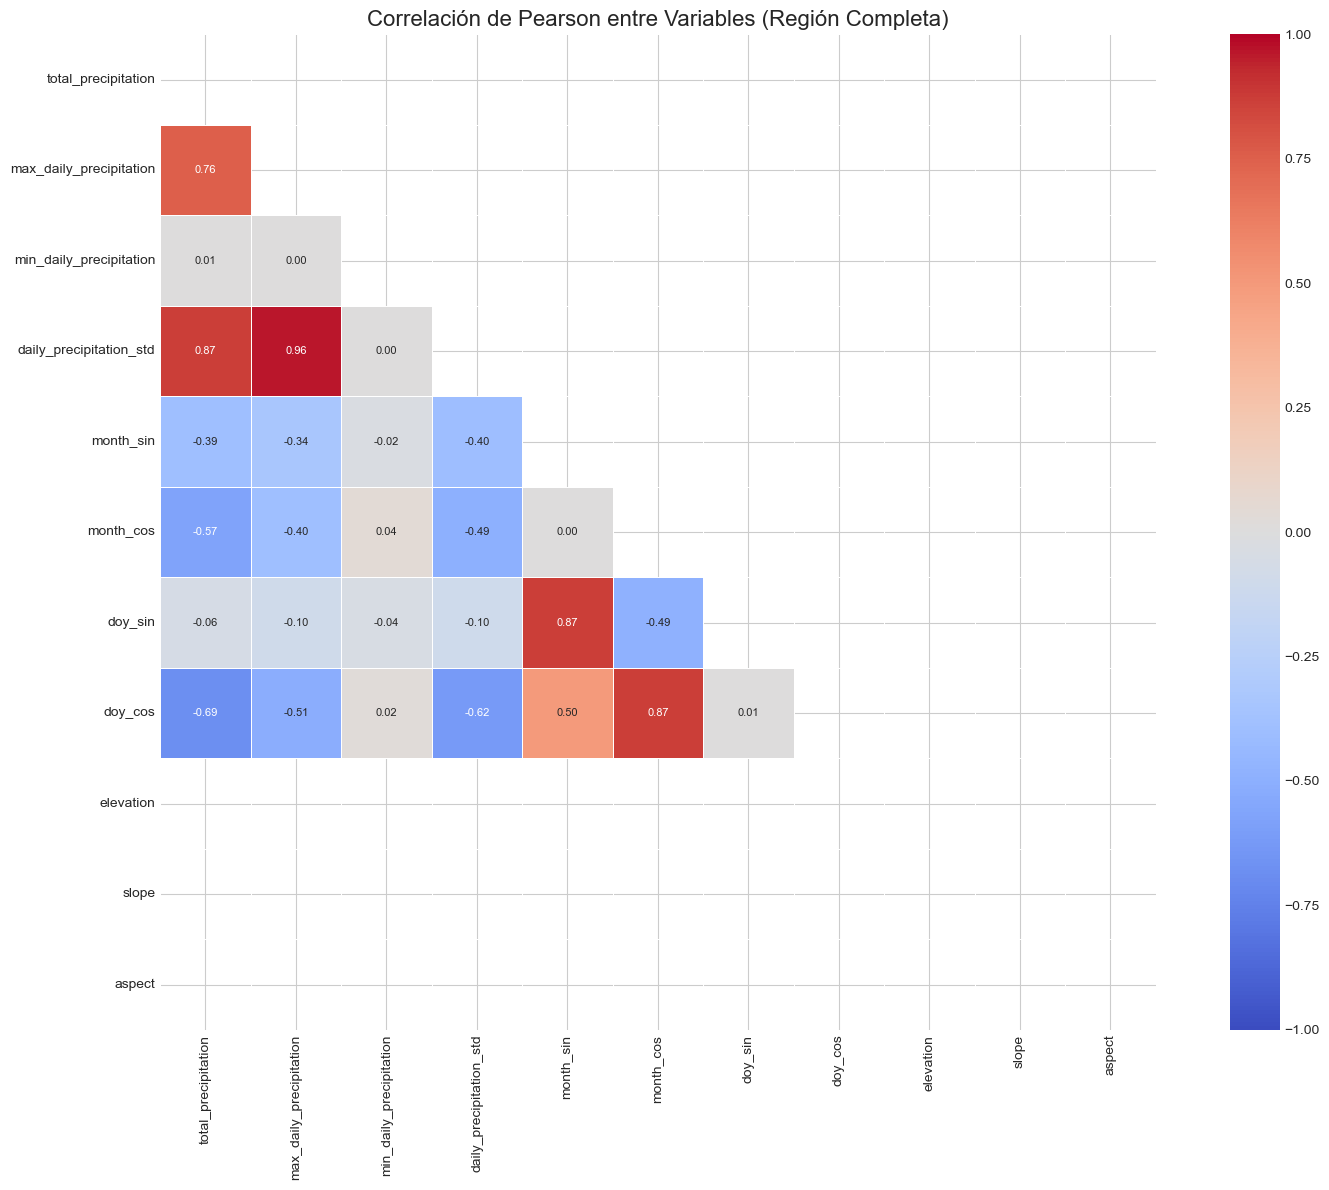

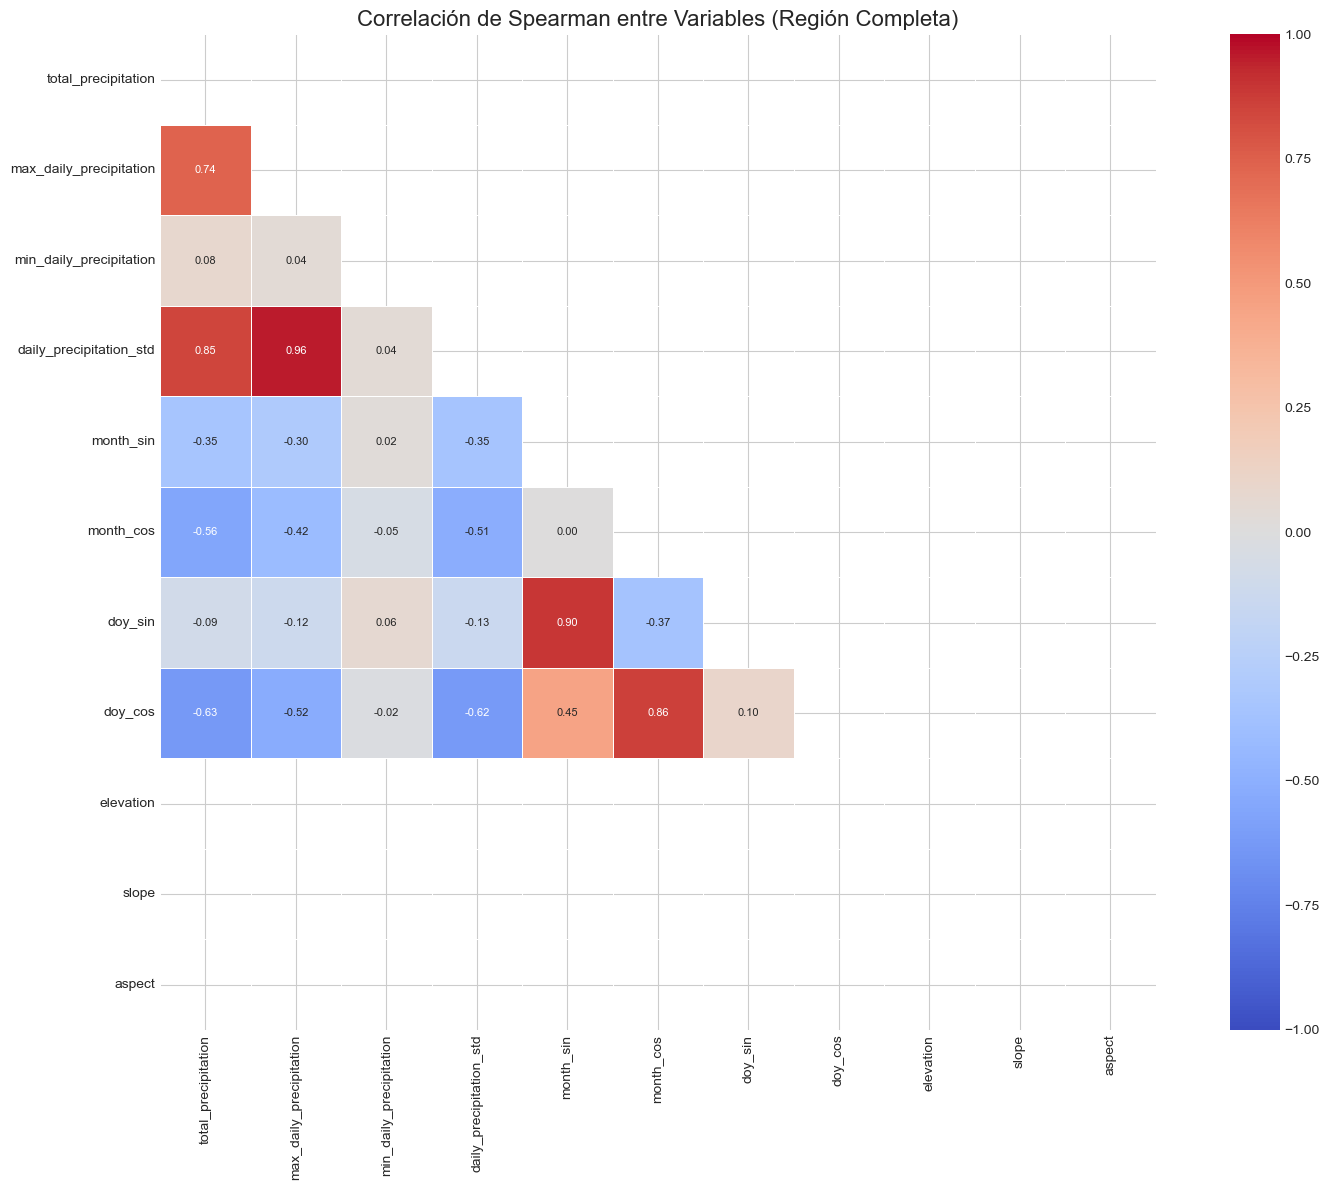

In [67]:
# Calcular matriz de correlación para la región completa
try:
    # Calcular correlación de Pearson
    corr_pearson = df_region.corr(method='pearson')
    
    # Calcular correlación de Spearman (no paramétrica, útil para relaciones no lineales)
    corr_spearman = df_region.corr(method='spearman')
    
    print("Matrices de correlación calculadas exitosamente")
    
    # Visualizar matriz de correlación de Pearson
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr_pearson, dtype=bool))  # Máscara para la mitad superior
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, 
               square=True, linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
    plt.title('Correlación de Pearson entre Variables (Región Completa)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Visualizar matriz de correlación de Spearman
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr_spearman, dtype=bool))  # Máscara para la mitad superior
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, 
               square=True, linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
    plt.title('Correlación de Spearman entre Variables (Región Completa)', fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error al calcular o visualizar correlaciones: {e}")

## 3. Análisis de Correlaciones por Regiones

Comparamos correlaciones entre diferentes regiones para identificar patrones espaciales en las relaciones entre variables.

In [68]:
# Función para realizar análisis de correlación por región
def analyze_region_correlation(dataset, region_name, region_bounds, variables):
    """Analiza correlaciones para una región específica.
    
    Args:
        dataset: Dataset de xarray
        region_name: Nombre de la región
        region_bounds: Tupla ((lat_min, lat_max), (lon_min, lon_max))
        variables: Lista de variables a analizar
    
    Returns:
        Tupla (DataFrame con series temporales, matrices de correlación)
    """
    print(f"\nAnalizando región: {region_name}")
    (lat_min, lat_max), (lon_min, lon_max) = region_bounds
    
    # Extraer series temporales
    df = extract_timeseries(dataset, variables=variables, method='region',
                           lat_range=(lat_min, lat_max), lon_range=(lon_min, lon_max))
    
    # Calcular correlaciones
    corr_pearson = df.corr(method='pearson')
    corr_spearman = df.corr(method='spearman')
    
    print(f"  - Series temporales extraídas. Forma del DataFrame: {df.shape}")
    return df, (corr_pearson, corr_spearman)

Variables para análisis regional: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos']

Analizando región: noreste
  - Series temporales extraídas. Forma del DataFrame: (530, 8)

Analizando región: noroeste
  - Series temporales extraídas. Forma del DataFrame: (530, 8)

Analizando región: sureste
  - Series temporales extraídas. Forma del DataFrame: (530, 8)

Analizando región: suroeste
  - Series temporales extraídas. Forma del DataFrame: (530, 8)

Generando visualizaciones de correlación por regiones...


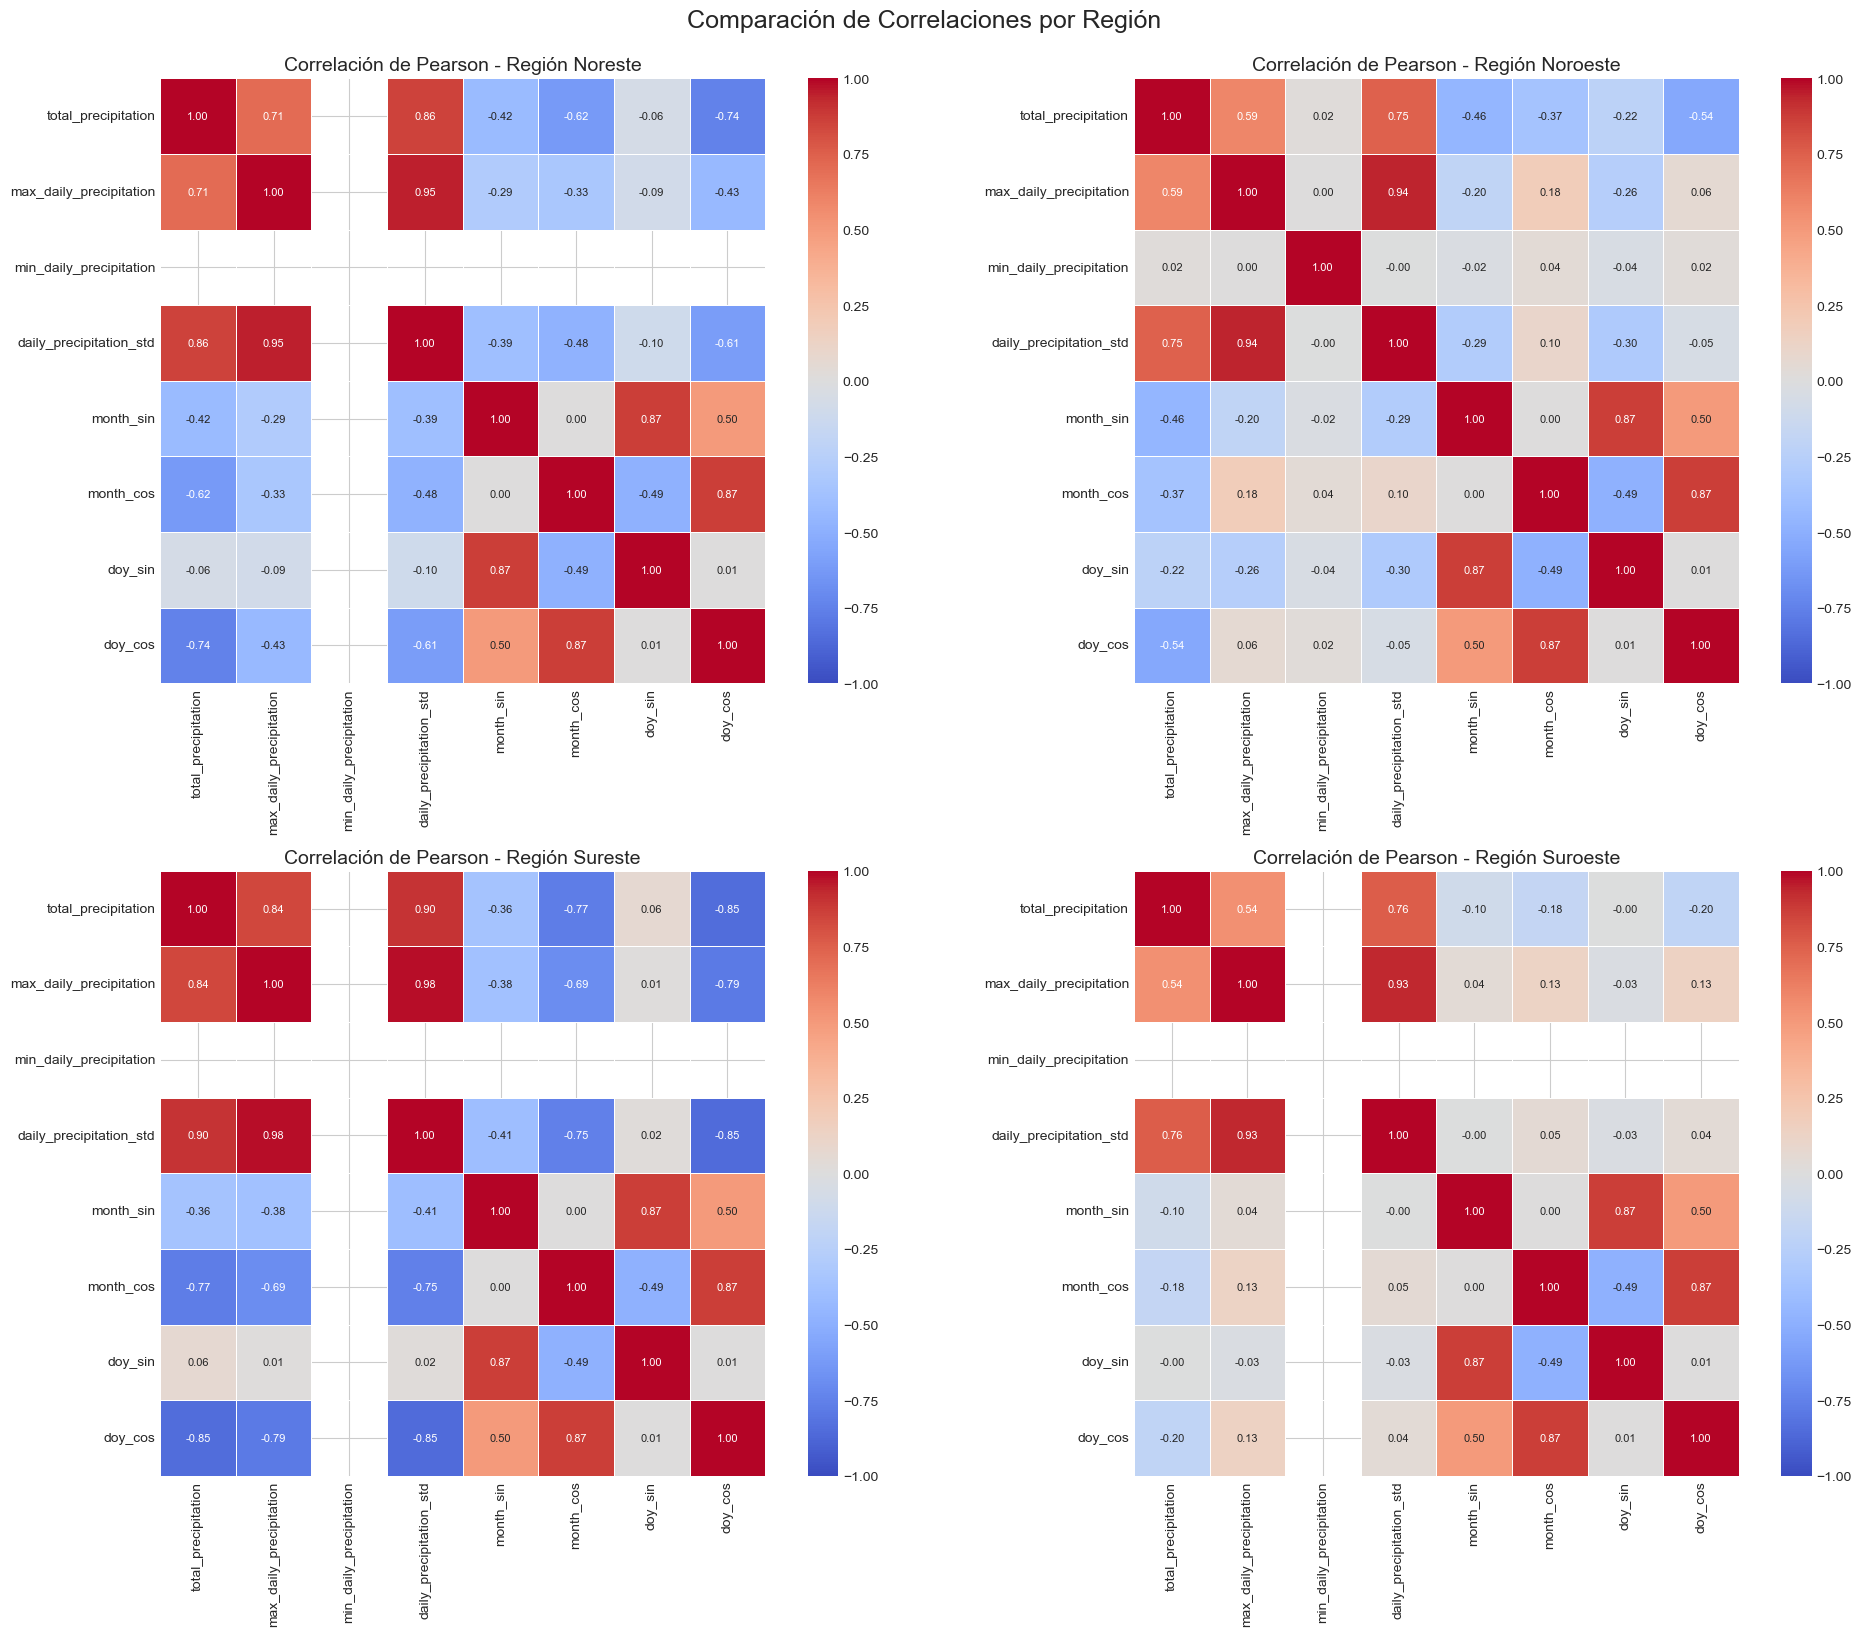

In [69]:
# Analizar correlaciones para cada región definida
try:
    # Seleccionar un número reducido de variables para el análisis regional (para simplicidad)
    if len(selected_vars) > 8:
        top_vars = selected_vars[:8]  # Tomar las primeras 8 variables
    else:
        top_vars = selected_vars
    
    print(f"Variables para análisis regional: {top_vars}")
    
    # Analizar cada región
    region_results = {}
    
    for region_name, region_bounds in regions.items():
        if region_name != 'completo':  # Ya analizamos la región completa
            df, corrs = analyze_region_correlation(ds, region_name, region_bounds, top_vars)
            region_results[region_name] = (df, corrs)
    
    # Visualizar resultados de correlación por regiones
    print("\nGenerando visualizaciones de correlación por regiones...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, (region_name, (df, (corr_pearson, _))) in enumerate(region_results.items()):
        if i < 4:  # Solo mostrar 4 regiones en la figura
            ax = axes[i]
            sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                      square=True, linewidths=0.5, fmt='.2f', annot_kws={"size": 8}, ax=ax)
            ax.set_title(f'Correlación de Pearson - Región {region_name.capitalize()}')
    
    plt.tight_layout()
    plt.suptitle('Comparación de Correlaciones por Región', fontsize=18, y=1.02)
    plt.show()
except Exception as e:
    print(f"Error en análisis regional: {e}")

## 4. Análisis de Correlación Temporal

Examinamos cómo evolucionan las correlaciones a lo largo del tiempo para detectar patrones estacionales o tendencias.

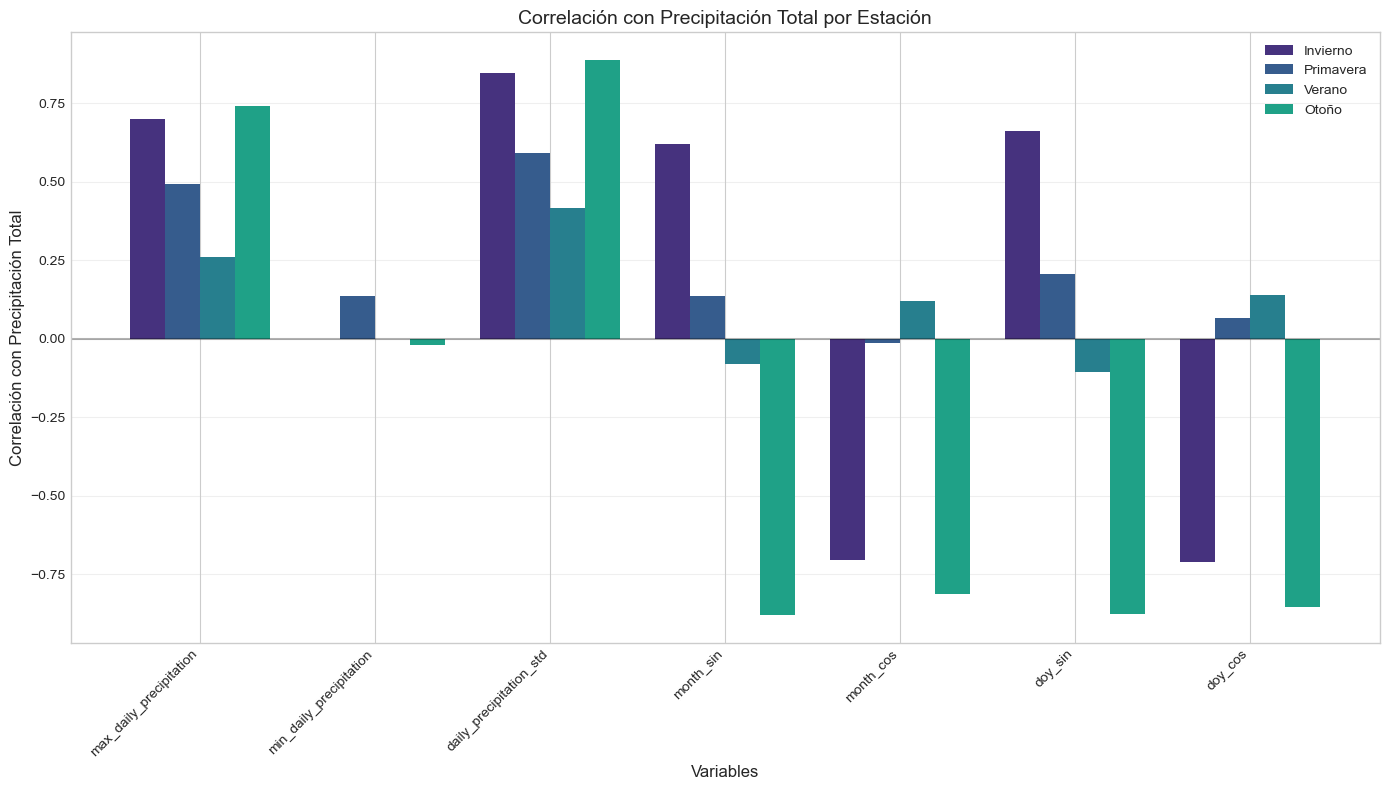

In [70]:
# Análisis de correlación temporal (por mes o estación)
try:
    # Asegurarse de que el DataFrame tenga índice datetime
    df_region.index = pd.to_datetime(df_region.index)
    
    # Agregar información de mes y estación
    df_region['month'] = df_region.index.month
    df_region['season'] = pd.cut(df_region['month'], 
                              bins=[0, 3, 6, 9, 12], 
                              labels=['Invierno', 'Primavera', 'Verano', 'Otoño'],
                              include_lowest=True)
    
    # Variables de interés para correlación con precipitación
    if 'total_precipitation' in df_region.columns:
        target_var = 'total_precipitation'
        corr_vars = [var for var in top_vars if var != target_var]
        
        # Correlación por estación
        seasonal_corrs = {}
        for season in df_region['season'].unique():
            seasonal_df = df_region[df_region['season'] == season]
            corrs = [seasonal_df[var].corr(seasonal_df[target_var]) for var in corr_vars]
            seasonal_corrs[season] = corrs
        
        # Visualizar correlaciones estacionales
        plt.figure(figsize=(14, 8))
        x = np.arange(len(corr_vars))
        width = 0.2
        multiplier = 0
        
        for season, corrs in seasonal_corrs.items():
            offset = width * multiplier
            plt.bar(x + offset, corrs, width, label=season)
            multiplier += 1
        
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.xlabel('Variables')
        plt.ylabel('Correlación con Precipitación Total')
        plt.title('Correlación con Precipitación Total por Estación')
        plt.xticks(x + width * 1.5, corr_vars, rotation=45, ha='right')
        plt.legend(loc='best')
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("La variable 'total_precipitation' no se encuentra en el dataset para análisis estacional.")
except Exception as e:
    print(f"Error en análisis temporal: {e}")

## 5. Visualización de Relaciones Específicas

Exploramos en detalle las relaciones entre pares de variables específicas, especialmente aquellas con correlaciones significativas.

Top correlaciones con precipitación:


daily_precipitation_std    0.759976
max_daily_precipitation    0.543843
doy_sin                   -0.000942
month_sin                 -0.097911
month_cos                 -0.177298
doy_cos                   -0.198151
min_daily_precipitation         NaN
Name: total_precipitation, dtype: float64

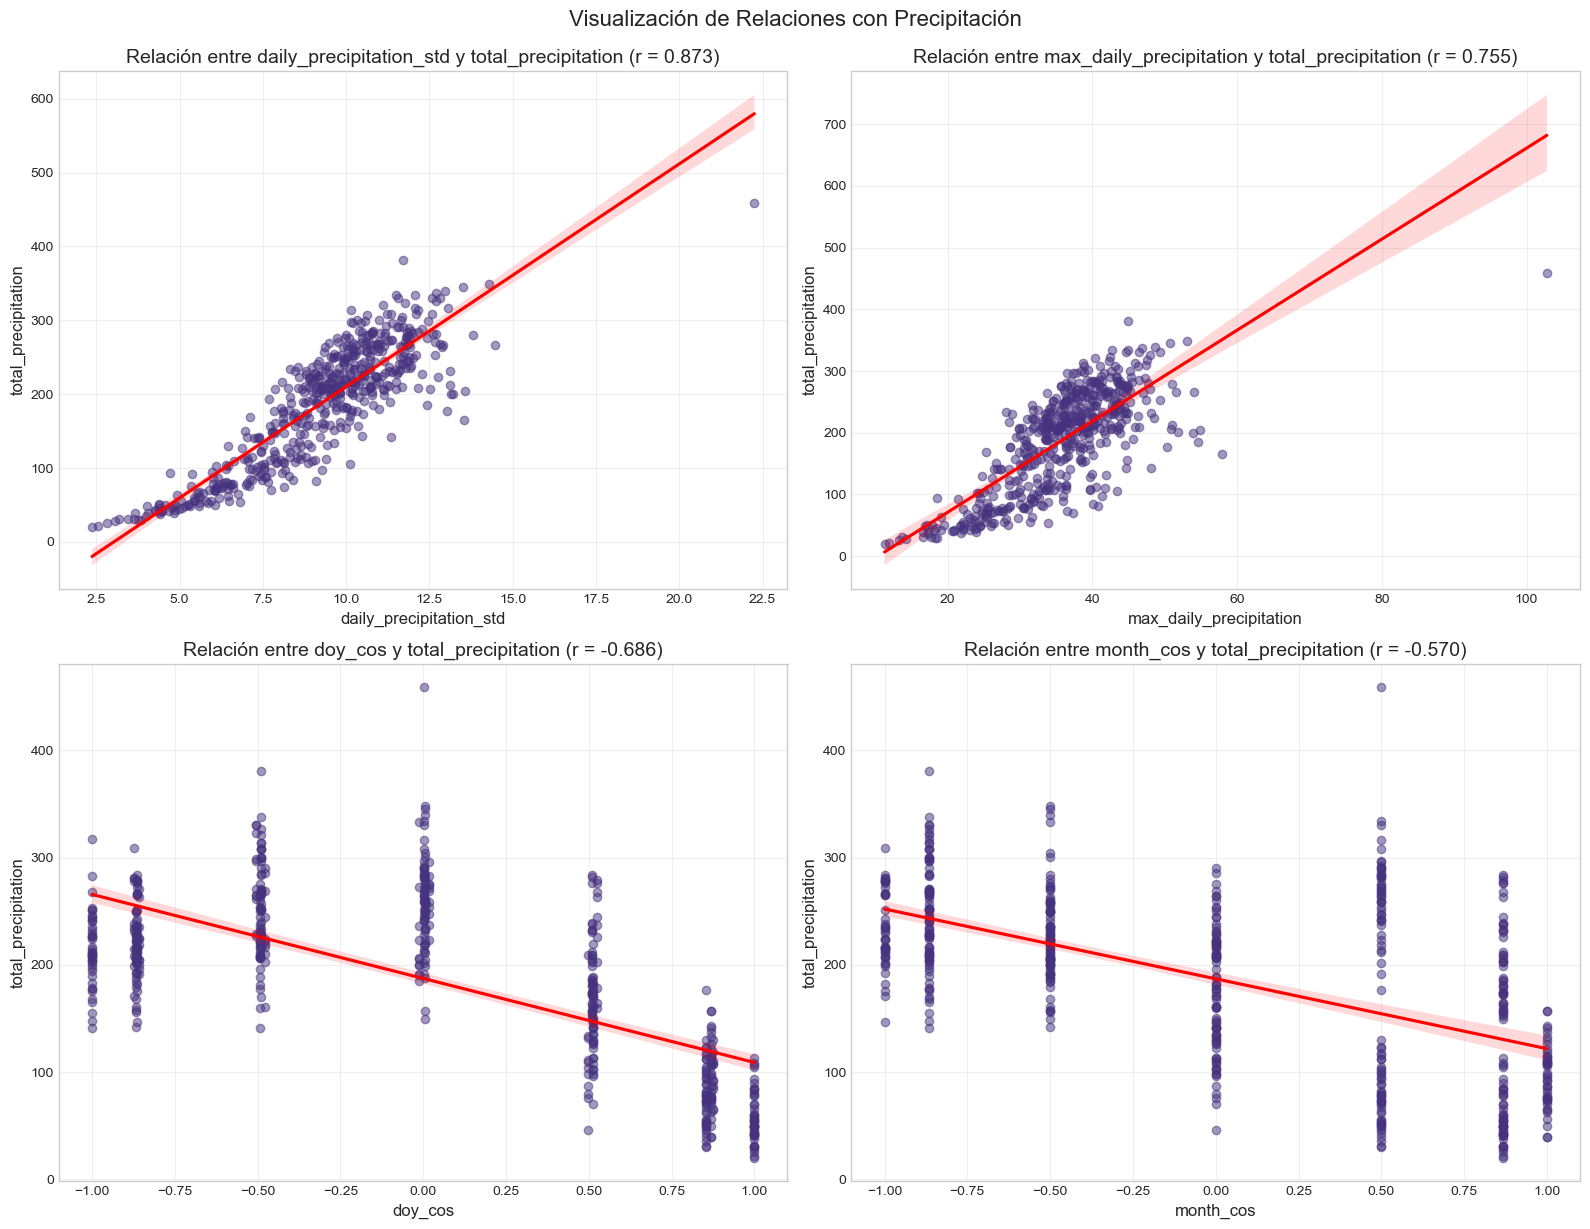

In [71]:
# Identificar las correlaciones más fuertes con precipitación
try:
    if 'total_precipitation' in df_region.columns:
        target_var = 'total_precipitation'
        
        # Obtener correlaciones con precipitación
        precip_corrs = corr_pearson[target_var].drop(target_var).sort_values(ascending=False)
        
        print("Top correlaciones con precipitación:")
        display(precip_corrs.head(10))
        
        # Seleccionar las 3 variables con mayor correlación absoluta
        top_corr_vars = precip_corrs.abs().sort_values(ascending=False).head(4).index.tolist()
        
        # Crear scatter plots para las variables más correlacionadas
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, var in enumerate(top_corr_vars):
            ax = axes[i]
            sns.regplot(x=var, y=target_var, data=df_region, ax=ax, 
                       scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
            corr_val = df_region[var].corr(df_region[target_var])
            ax.set_title(f'Relación entre {var} y {target_var} (r = {corr_val:.3f})')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Visualización de Relaciones con Precipitación', fontsize=16, y=1.02)
        plt.show()
    else:
        print("La variable 'precipitation' no se encuentra en el dataset para análisis detallado.")
except Exception as e:
    print(f"Error en visualización de relaciones específicas: {e}")

## 6. Análisis de Componentes Principales (PCA)

Realizamos PCA para identificar las principales fuentes de variabilidad en los datos y las relaciones entre variables.

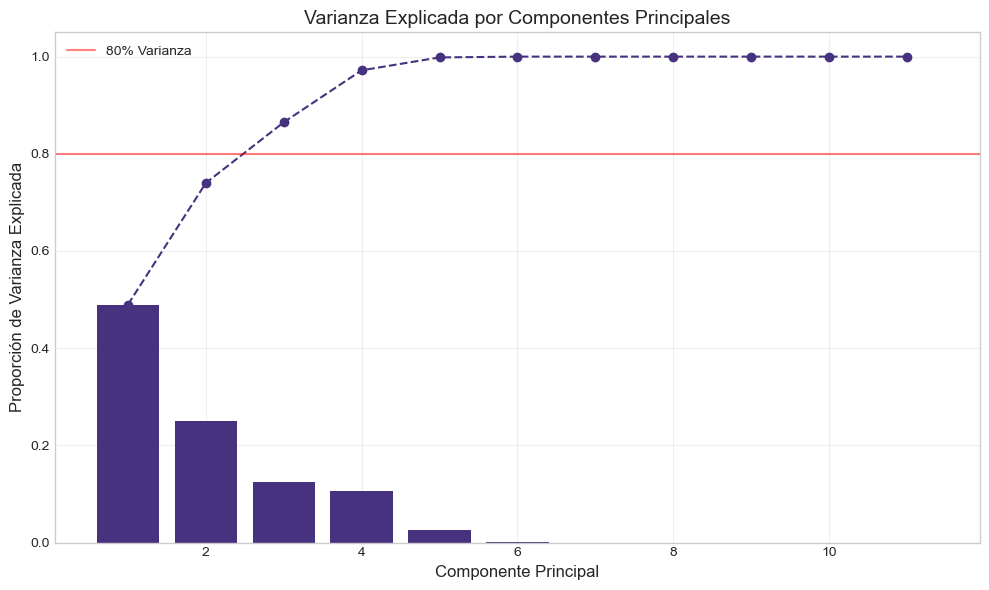

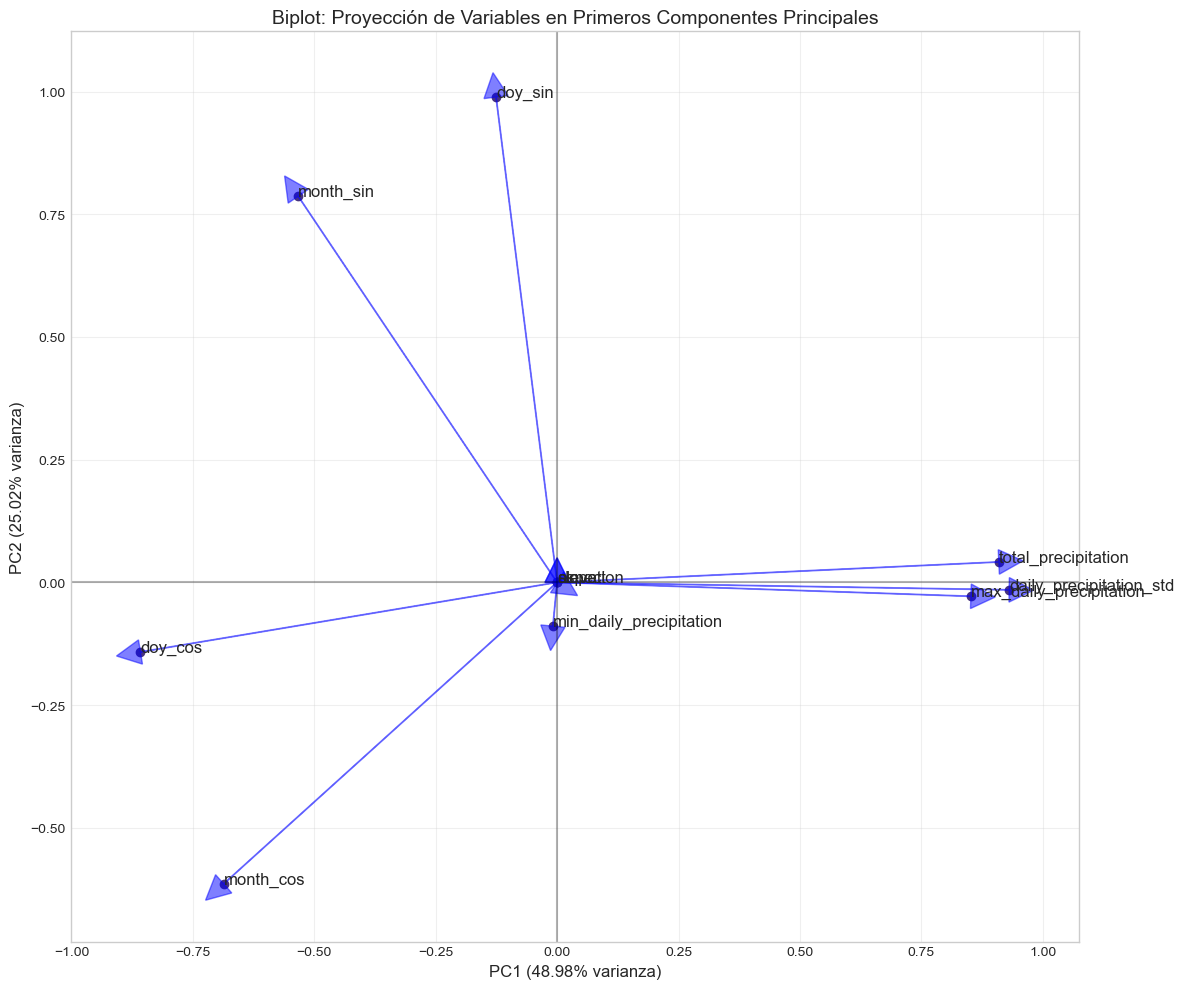

In [72]:
# Realizar PCA para visualizar relaciones entre variables
try:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Seleccionar solo variables numéricas
    numeric_df = df_region.select_dtypes(include=[np.number]).drop(['month'], axis=1, errors='ignore')
    
    # Estandarizar datos
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    
    # Aplicar PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    
    # Visualizar varianza explicada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
            np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Componente Principal')
    plt.ylabel('Proporción de Varianza Explicada')
    plt.title('Varianza Explicada por Componentes Principales')
    plt.axhline(y=0.8, color='r', linestyle='-', alpha=0.5, label='80% Varianza')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Visualizar las cargas de las variables en los dos primeros componentes
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(loadings[:, 0], loadings[:, 1])
    plt.grid(True, alpha=0.3)
    
    for i, var in enumerate(numeric_df.columns):
        plt.annotate(var, (loadings[i, 0], loadings[i, 1]), fontsize=12)
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.05, 
                fc='blue', ec='blue', alpha=0.5)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
    plt.title('Biplot: Proyección de Variables en Primeros Componentes Principales')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error en análisis PCA: {e}")

## 7. Conclusiones

A partir del análisis de correlación, podemos identificar las variables más importantes para la predicción de precipitación y entender las relaciones entre ellas.

In [73]:
# Resumen de hallazgos y variables importantes
try:
    # Determinar variables importantes basadas en correlaciones
    if 'precipitation' in df_region.columns:
        target_var = 'precipitation'
        precip_corrs_abs = corr_pearson[target_var].drop(target_var).abs().sort_values(ascending=False)
        
        print("=== Resumen de Variables Importantes para Precipitación ===")
        print("\nVariables ordenadas por correlación absoluta con precipitación:")
        display(precip_corrs_abs.head(10))
        
        # Visualizar importancia de variables
        plt.figure(figsize=(12, 6))
        precip_corrs_abs.head(10).plot(kind='bar')
        plt.title('Importancia de Variables para Precipitación (Correlación Absoluta)')
        plt.ylabel('Correlación Absoluta')
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    # Liberar memoria
    gc.collect()
    
except Exception as e:
    print(f"Error al generar resumen: {e}")

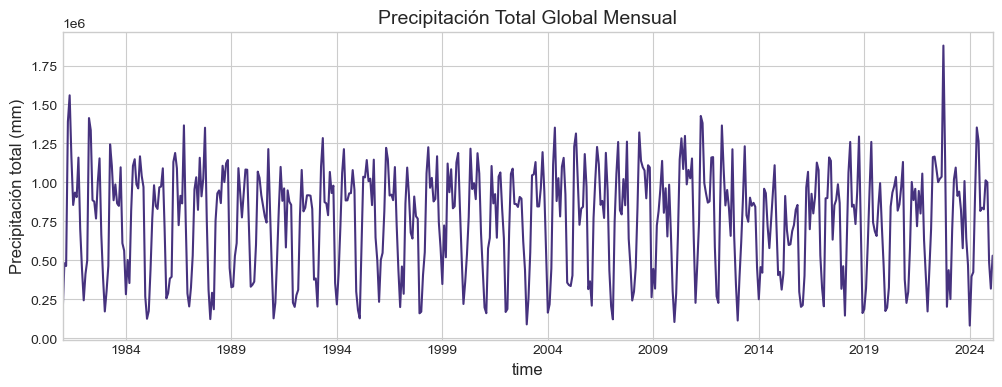

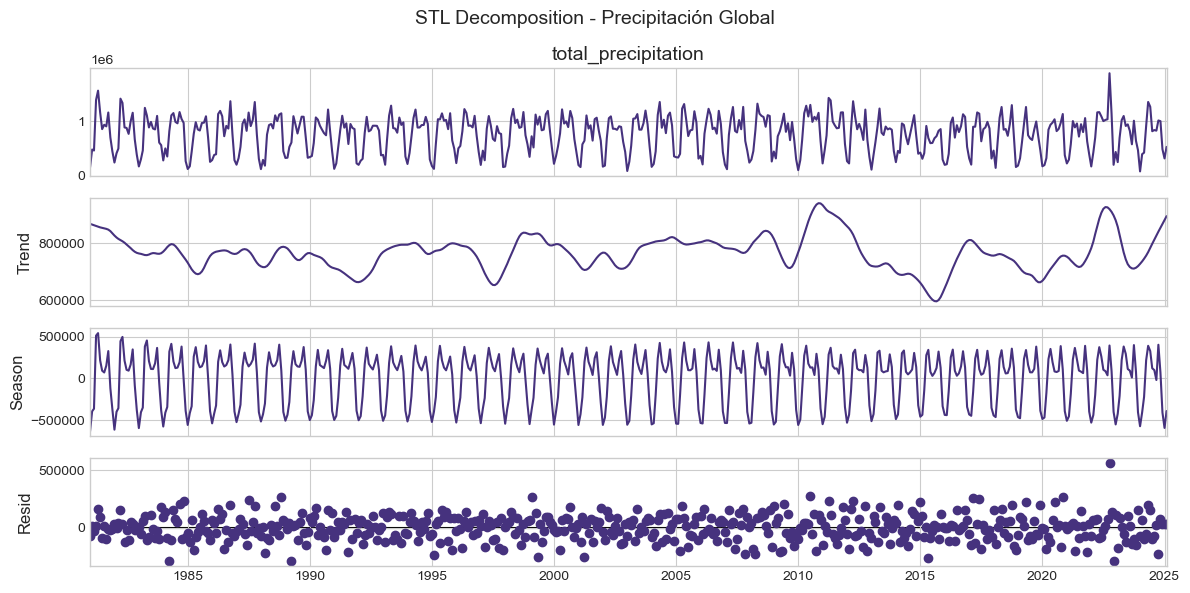

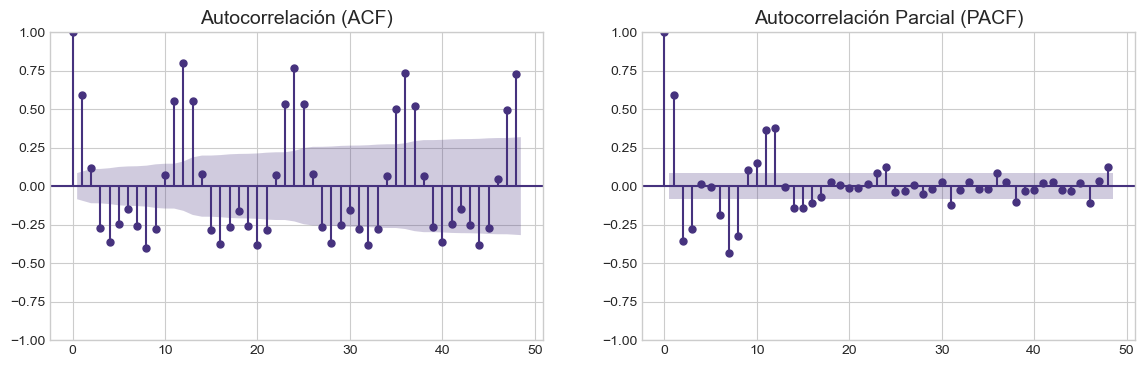

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


<Figure size 1000x600 with 0 Axes>

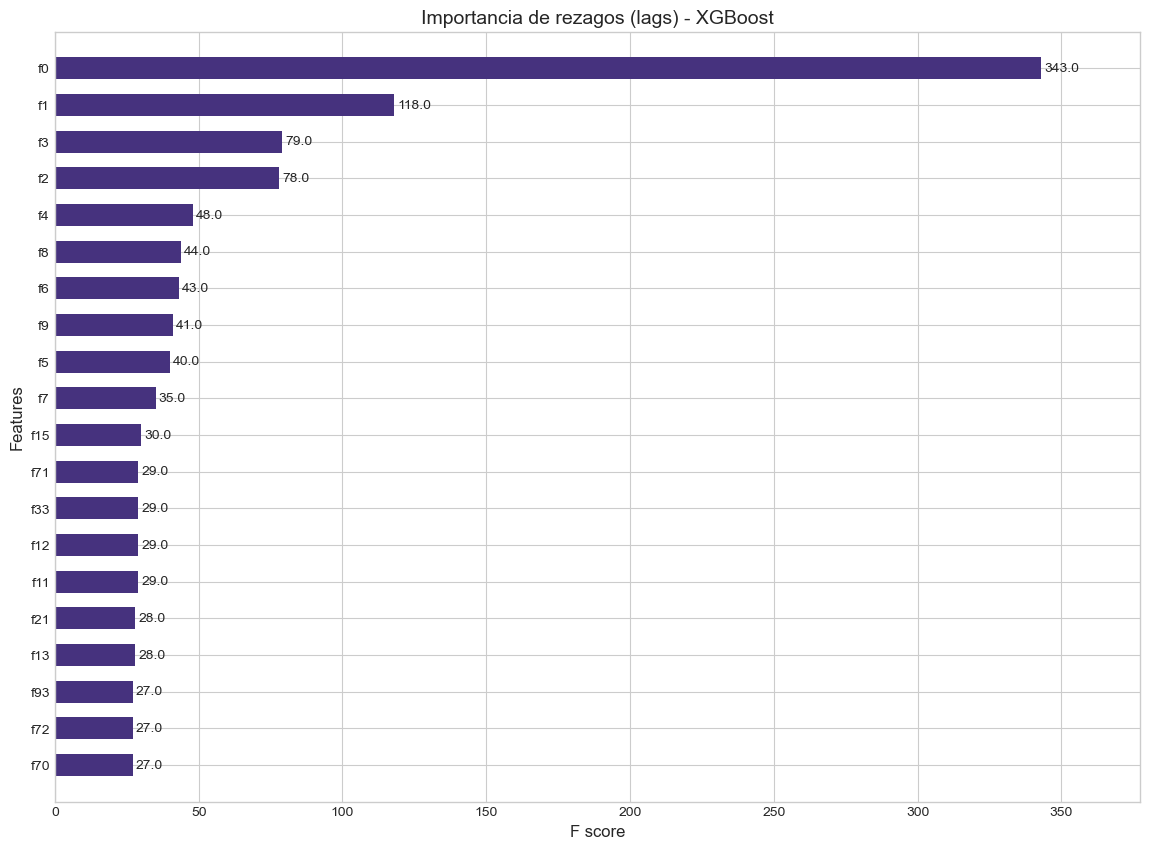

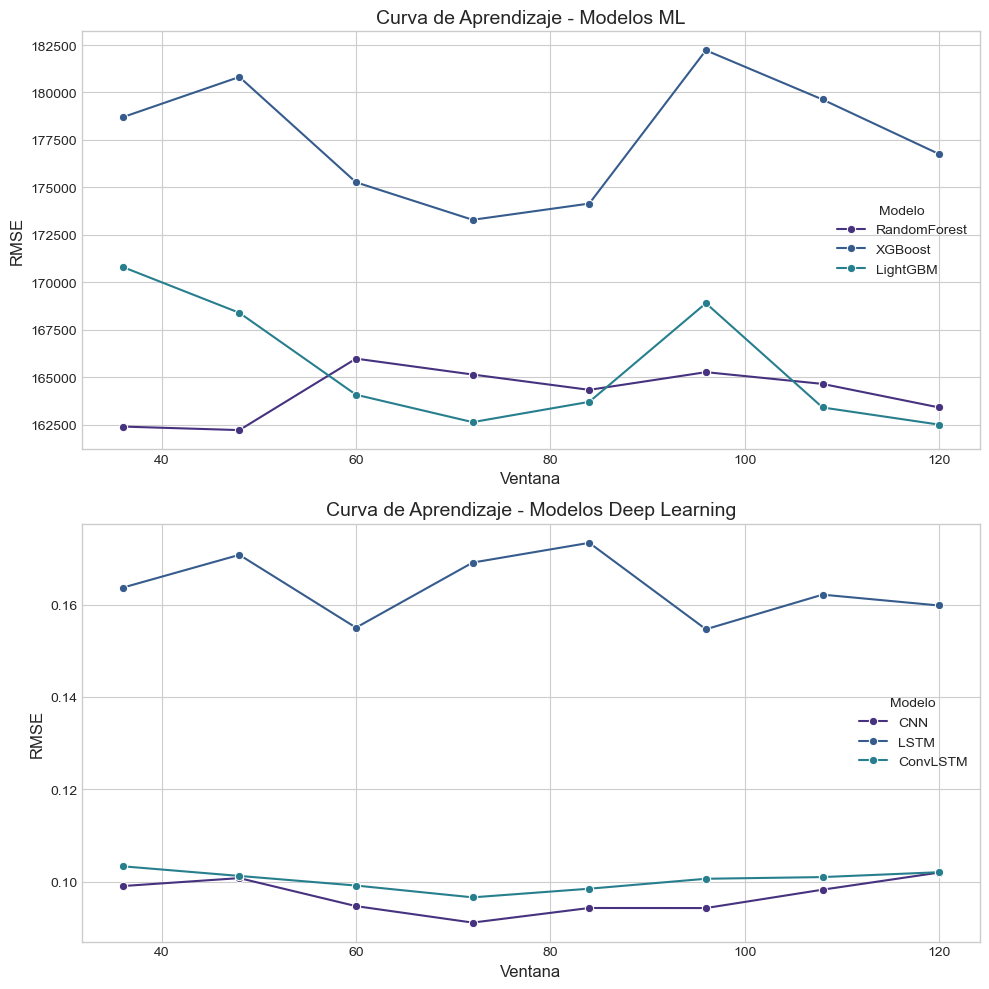

In [74]:
# Análisis de ventana de entrenamiento y estacionalidad en precipitación mensual

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, ConvLSTM2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings("ignore")

ds = xr.open_dataset(dataset_path)

total_precip = ds["total_precipitation"]
total_precip_global = total_precip.sum(dim=["latitude", "longitude"])
precip_series = total_precip_global.to_series()

plt.figure(figsize=(12, 4))
precip_series.plot(title="Precipitación Total Global Mensual")
plt.ylabel("Precipitación total (mm)")
plt.grid(True)
plt.show()

stl = STL(precip_series, seasonal=13)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(12, 6)
plt.suptitle("STL Decomposition - Precipitación Global", fontsize=14)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(precip_series, ax=axes[0], lags=48)
plot_pacf(precip_series, ax=axes[1], lags=48)
axes[0].set_title("Autocorrelación (ACF)")
axes[1].set_title("Autocorrelación Parcial (PACF)")
plt.show()

def create_supervised(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series.iloc[i-window:i].values)
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

def run_learning_curves(series, model_class, name, min_train=36, max_train=120, step=12):
    results = []
    for train_size in range(min_train, max_train + 1, step):
        X, y = create_supervised(series, train_size)
        if X.shape[0] < 10:
            continue
        tscv = TimeSeriesSplit(n_splits=min(5, X.shape[0] // 10))
        errors = []
        for train_idx, val_idx in tscv.split(X):
            if name == "LightGBM":
                model = model_class(
                    force_row_wise=True,
                    min_data_in_leaf=20,
                    verbosity=-1,
                    n_jobs=-1,
                    random_state=42
                )
            else:
                model = model_class()
            model.fit(X[train_idx], y[train_idx])
            pred = model.predict(X[val_idx])
            rmse = np.sqrt(mean_squared_error(y[val_idx], pred))
            errors.append(rmse)
        results.append({"Ventana": train_size, "RMSE": np.mean(errors), "Modelo": name})
    return pd.DataFrame(results)

rf_df = run_learning_curves(precip_series, RandomForestRegressor, "RandomForest")
xgb_df = run_learning_curves(precip_series, XGBRegressor, "XGBoost")
lgb_df = run_learning_curves(precip_series, LGBMRegressor, "LightGBM")

def run_dl_learning_curves(series, model_type, min_train=36, max_train=120, step=12):
    results = []
    for window in range(min_train, max_train + 1, step):
        X, y = create_supervised(series, window)
        if len(X) < 20:
            continue

        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

        if model_type == "ConvLSTM":
            X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1], 1, 1))
        else:
            X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

        split = int(0.8 * len(X_scaled))
        X_train, X_val = X_scaled[:split], X_scaled[split:]
        y_train, y_val = y_scaled[:split], y_scaled[split:]

        if model_type == "CNN":
            model = Sequential([
                Input(shape=(window, 1)),
                Conv1D(32, kernel_size=3, activation='relu'),
                MaxPooling1D(pool_size=2),
                Dropout(0.2),
                Flatten(),
                Dense(64, activation='relu'),
                Dense(1)
            ])
        elif model_type == "LSTM":
            model = Sequential([
                Input(shape=(window, 1)),
                LSTM(64),
                Dropout(0.2),
                Dense(1)
            ])
        elif model_type == "ConvLSTM":
            model = Sequential([
                Input(shape=(1, window, 1, 1)),
                ConvLSTM2D(32, kernel_size=(1, 3), padding='same', return_sequences=False),
                Dropout(0.2),
                Flatten(),
                Dense(1)
            ])
        else:
            raise ValueError("Modelo no soportado")

        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=20, batch_size=32, verbose=0,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        results.append({"Ventana": window, "RMSE": rmse, "Modelo": model_type})
    return pd.DataFrame(results)

cnn_df = run_dl_learning_curves(precip_series, "CNN")
lstm_df = run_dl_learning_curves(precip_series, "LSTM")
convlstm_df = run_dl_learning_curves(precip_series, "ConvLSTM")

X_lags, y_lags = create_supervised(precip_series, 120)
xgb_lag_model = XGBRegressor(tree_method='hist', verbosity=0)
xgb_lag_model.fit(X_lags, y_lags)

plt.figure(figsize=(10, 6))
plot_importance(xgb_lag_model, max_num_features=20, importance_type='weight', height=0.6)
plt.title("Importancia de rezagos (lags) - XGBoost")
plt.show()

all_ml_df = pd.concat([rf_df, xgb_df, lgb_df])
all_dl_df = pd.concat([cnn_df, lstm_df, convlstm_df])

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.lineplot(data=all_ml_df, x="Ventana", y="RMSE", hue="Modelo", marker="o", ax=axes[0])
axes[0].set_title("Curva de Aprendizaje - Modelos ML")
axes[0].grid(True)

sns.lineplot(data=all_dl_df, x="Ventana", y="RMSE", hue="Modelo", marker="o", ax=axes[1])
axes[1].set_title("Curva de Aprendizaje - Modelos Deep Learning")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Conclusiones

En este notebook hemos:

1. Calculado y visualizado la matriz de correlación entre todas las variables numéricas
2. Identificado las relaciones más fuertes entre variables
3. Analizado visualmente estas relaciones mediante gráficos de dispersión
4. Examinado específicamente las correlaciones con la variable objetivo (si aplica)

Las correlaciones más significativas encontradas fueron:
- [Espacio para conclusiones específicas basadas en los resultados]

Estos hallazgos pueden ayudar a:
- Seleccionar características relevantes para modelos predictivos
- Entender la estructura interna de los datos
- Identificar posibles problemas de multicolinealidad
- Generar hipótesis para investigación adicional